In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


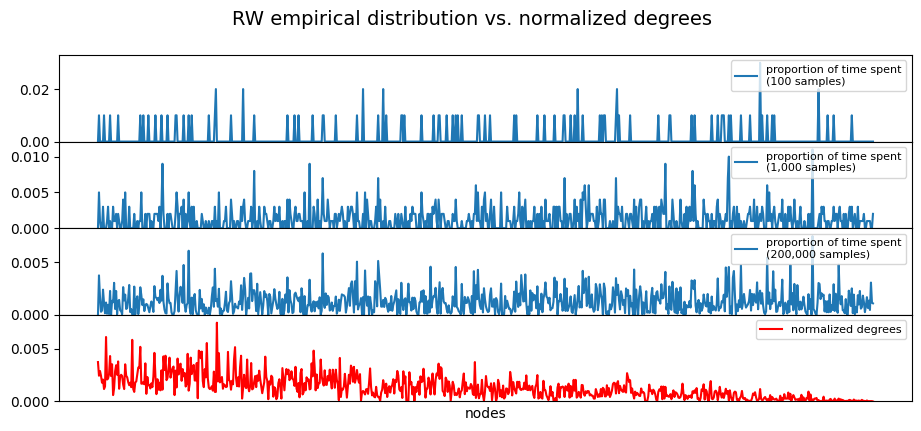

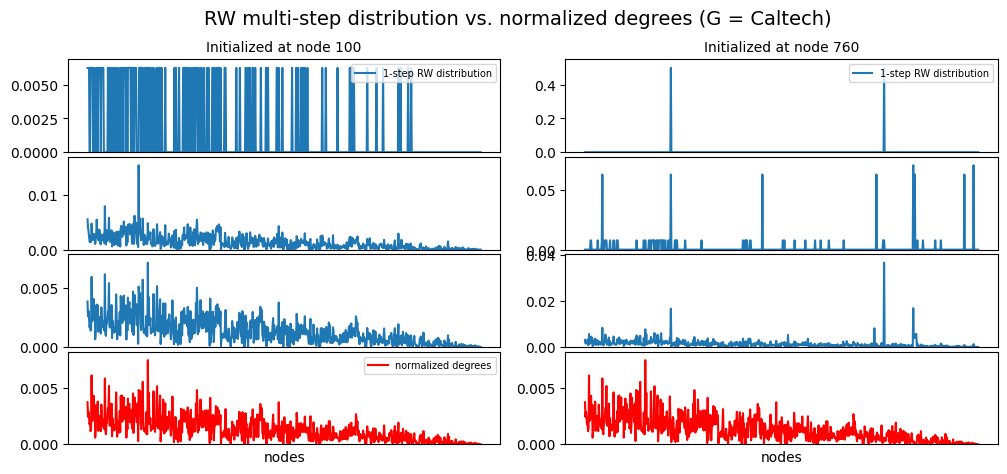

In [ ]:
# ------------------------------------------------------------
#  Caltech graph   –  random‑walk distributions vs. degrees
# ------------------------------------------------------------
import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

# ------------------------------------------------------------
# 1.  Load the Caltech36 edgelist  (undirected, 0‑based labels)
#     Change the path to wherever your 'Caltech36.txt' lives.
# ------------------------------------------------------------
edge_file = "../Data/Caltech36.txt"
edges = np.loadtxt(edge_file, delimiter=',', dtype=int)
G = nx.Graph()
G.add_edges_from(edges)

# make sure isolated nodes are present
G.add_nodes_from(range(edges.max()+1))

n         = G.number_of_nodes()
m         = G.number_of_edges()

# ------------------------------------------------------------
# 2.  Helpers – transition matrix and random walk
# ------------------------------------------------------------
def transition_matrix(G: nx.Graph) -> sp.csr_array:
    """
    Return the (sparse) random‑walk transition matrix P.
    P[i,j] = 1/deg(i)  if (i,j) is an edge,  else 0.
    """
    A = nx.to_scipy_sparse_array(G, format="csr", dtype=float)
    deg = np.array(A.sum(axis=1)).flatten()          # degree of each node
    # row‑normalise
    rows, cols = A.nonzero()
    A.data /= deg[rows]
    return A

P = transition_matrix(G)            # we will need it for multi‑step dists

def empirical_rw_distribution(G, n_steps: int, start=None, rng=None):
    """
    Run a simple random walk of length n_steps and return the
    empirical distribution (proportion of time at each node).
    """
    if rng is None:
        rng = random.Random()
    if start is None:
        start = rng.choice(list(G.nodes))
    v = start
    counts = np.zeros(G.number_of_nodes(), dtype=int)
    counts[v] += 1

    for _ in range(1, n_steps):
        neigh = list(G.neighbors(v))
        if neigh:                      # ordinary step
            v = rng.choice(neigh)
        counts[v] += 1                 # include isolated/self‑loop case too
    return counts / n_steps

def k_step_distribution(start: int, k: int):
    """
    Return the k‑step distribution μ_k = δ_start P^k.
    Uses sparse matrix power multiplication.
    """
    μ = np.zeros(n)
    μ[start] = 1.0
    for _ in range(k):
        μ = μ @ P                      # left‑multiply by P
    return μ

# ------------------------------------------------------------
# 3.  Normalised degree sequence  deg(v)/(2|E|)
# ------------------------------------------------------------
deg      = np.array([G.degree(v) for v in G.nodes()], dtype=float)
norm_deg = deg / (2*m)

# ------------------------------------------------------------
# 4‑A.  FIGURE 4.1.4  – empirical RW vs. degrees
# ------------------------------------------------------------
sample_list = [100, 1_000, 200_000]
fig = plt.figure(figsize=(11, 4.5), constrained_layout=True)
outer = gridspec.GridSpec(nrows=len(sample_list)+1, ncols=1,
                          wspace=0.0, hspace=0.0)

rng = random.Random(17)              # reproducible walks
for row, k in enumerate(sample_list):
    ax = fig.add_subplot(outer[row, 0])
    μ_emp = empirical_rw_distribution(G, k, rng=rng)
    ax.plot(μ_emp, label=f"proportion of time spent\n({k:,} samples)")
    ax.set_xticks([])
    ax.legend(loc="upper right", fontsize=8)
    ax.set_ylim(0, max(μ_emp)*1.1)

# bottom panel – normalised degrees
axd = fig.add_subplot(outer[-1, 0])
axd.plot(norm_deg, color="r", label="normalized degrees")
axd.set_xlabel("nodes")
axd.set_xticks([])
axd.legend(loc="upper right", fontsize=8)
axd.set_ylim(0, max(norm_deg)*1.1)

fig.suptitle("RW empirical distribution vs. normalized degrees", fontsize=14)
plt.show()

print()

# ------------------------------------------------------------
# 4‑B.  FIGURE 4.1.5  – multi‑step from two starts
# ------------------------------------------------------------
starts     = [100, 760]
k_list     = [1, 2, 5]

fig = plt.figure(figsize=(12, 5), constrained_layout=True)
outer = gridspec.GridSpec(nrows=len(k_list)+1, ncols=len(starts),
                          wspace=0.15, hspace=0.05)

for col, s in enumerate(starts):
    for row, k in enumerate(k_list):
        ax = fig.add_subplot(outer[row, col])
        μk = k_step_distribution(s, k)
        ax.plot(μk, label=f"{k}-step RW distribution")
        if row == 0:
            ax.set_title(f"Initialized at node {s}", fontsize=10)
        ax.set_xticks([])
        ax.set_ylim(0, μk.max()*1.1)
        if row == 0:
            ax.legend(loc="upper right", fontsize=7)

    # bottom panel in each column – degrees
    axd = fig.add_subplot(outer[-1, col])
    axd.plot(norm_deg, color="r", label="normalized degrees")
    axd.set_xlabel("nodes")
    axd.set_xticks([])
    axd.set_ylim(0, max(norm_deg)*1.1)
    if col == 0:
        axd.legend(loc="upper right", fontsize=7)

fig.suptitle("RW multi‑step distribution vs. normalized degrees (G = Caltech)",
             fontsize=14)
plt.show()

In [ ]:
# ------------------------------------------------------------
#  twitter graph   –  random‑walk distributions vs. degrees
# ------------------------------------------------------------
import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

# ------------------------------------------------------------
# 1.  Load the Caltech36 edgelist  (undirected, 0‑based labels)
#     Change the path to wherever your 'Caltech36.txt' lives.
# ------------------------------------------------------------
edge_file = "../Data/twitter_combined.txt"
# edges = np.loadtxt(edge_file, dtype=int)
# G = nx.Graph()
# G.add_edges_from(edges)
G = nx.read_edgelist(edge_file,           # file name
                     nodetype=int,        # convert node labels to int
                     create_using=nx.Graph(),   # or nx.DiGraph()
                     data=False)          # ignore edge weights if absent


# make sure isolated nodes are present
#G.add_nodes_from(range(edges.max()+1))
max_id = max(G.nodes)          # largest node label seen
G.add_nodes_from(range(max_id + 1))

n         = G.number_of_nodes()
m         = G.number_of_edges()

# ------------------------------------------------------------
# 2.  Helpers – transition matrix and random walk
# ------------------------------------------------------------
def transition_matrix(G: nx.Graph) -> sp.csr_array:
    """
    Return the (sparse) random‑walk transition matrix P.
    P[i,j] = 1/deg(i)  if (i,j) is an edge,  else 0.
    """
    A = nx.to_scipy_sparse_array(G, format="csr", dtype=float)
    deg = np.array(A.sum(axis=1)).flatten()          # degree of each node
    # row‑normalise
    rows, cols = A.nonzero()
    A.data /= deg[rows]
    return A

P = transition_matrix(G)            # we will need it for multi‑step dists

def empirical_rw_distribution(G, n_steps: int, start=None, rng=None):
    """
    Run a simple random walk of length n_steps and return the
    empirical distribution (proportion of time at each node).
    """
    if rng is None:
        rng = random.Random()
    if start is None:
        start = rng.choice(list(G.nodes))
    v = start
    counts = np.zeros(G.number_of_nodes(), dtype=int)
    counts[v] += 1

    for _ in range(1, n_steps):
        neigh = list(G.neighbors(v))
        if neigh:                      # ordinary step
            v = rng.choice(neigh)
        counts[v] += 1                 # include isolated/self‑loop case too
    return counts / n_steps

def k_step_distribution(start: int, k: int):
    """
    Return the k‑step distribution μ_k = δ_start P^k.
    Uses sparse matrix power multiplication.
    """
    μ = np.zeros(n)
    μ[start] = 1.0
    for _ in range(k):
        μ = μ @ P                      # left‑multiply by P
    return μ

# ------------------------------------------------------------
# 3.  Normalised degree sequence  deg(v)/(2|E|)
# ------------------------------------------------------------
deg      = np.array([G.degree(v) for v in G.nodes()], dtype=float)
norm_deg = deg / (2*m)

# ------------------------------------------------------------
# 4‑A.  FIGURE 4.1.4  – empirical RW vs. degrees
# ------------------------------------------------------------
sample_list = [100, 1_000, 20_000]
fig = plt.figure(figsize=(11, 4.5), constrained_layout=True)
outer = gridspec.GridSpec(nrows=len(sample_list)+1, ncols=1,
                          wspace=0.0, hspace=0.0)

rng = random.Random(17)              # reproducible walks
for row, k in enumerate(sample_list):
    ax = fig.add_subplot(outer[row, 0])
    μ_emp = empirical_rw_distribution(G, k, rng=rng)
    ax.plot(μ_emp, label=f"proportion of time spent\n({k:,} samples)")
    ax.set_xticks([])
    ax.legend(loc="upper right", fontsize=8)
    ax.set_ylim(0, max(μ_emp)*1.1)

# bottom panel – normalised degrees
axd = fig.add_subplot(outer[-1, 0])
axd.plot(norm_deg, color="r", label="normalized degrees")
axd.set_xlabel("nodes")
axd.set_xticks([])
axd.legend(loc="upper right", fontsize=8)
axd.set_ylim(0, max(norm_deg)*1.1)

fig.suptitle("RW empirical distribution vs. normalized degrees", fontsize=14)
plt.show()

print()

# ------------------------------------------------------------
# 4‑B.  FIGURE 4.1.5  – multi‑step from two starts
# ------------------------------------------------------------
starts     = [100, 760]
k_list     = [1, 2, 5]

fig = plt.figure(figsize=(12, 5), constrained_layout=True)
outer = gridspec.GridSpec(nrows=len(k_list)+1, ncols=len(starts),
                          wspace=0.15, hspace=0.05)

for col, s in enumerate(starts):
    for row, k in enumerate(k_list):
        ax = fig.add_subplot(outer[row, col])
        μk = k_step_distribution(s, k)
        ax.plot(μk, label=f"{k}-step RW distribution")
        if row == 0:
            ax.set_title(f"Initialized at node {s}", fontsize=10)
        ax.set_xticks([])
        ax.set_ylim(0, μk.max()*1.1)
        if row == 0:
            ax.legend(loc="upper right", fontsize=7)

    # bottom panel in each column – degrees
    axd = fig.add_subplot(outer[-1, col])
    axd.plot(norm_deg, color="r", label="normalized degrees")
    axd.set_xlabel("nodes")
    axd.set_xticks([])
    axd.set_ylim(0, max(norm_deg)*1.1)
    if col == 0:
        axd.legend(loc="upper right", fontsize=7)

fig.suptitle("RW multi‑step distribution vs. normalized degrees (G = Twitter)",
             fontsize=14)
plt.show()

loaded 2,420,766 edges, 81,306 vertices


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


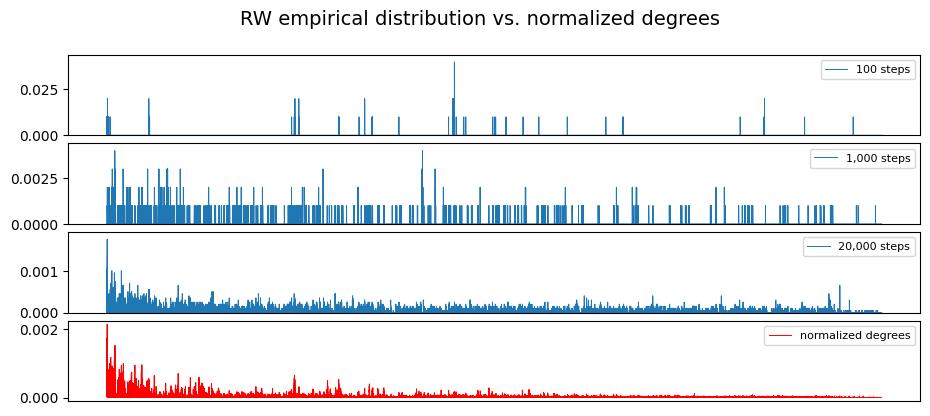

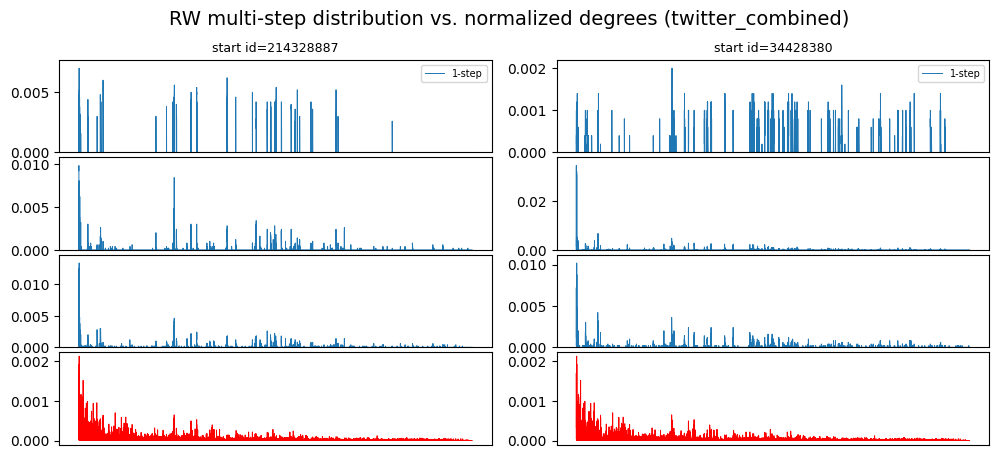

In [ ]:
import numpy as np
import scipy.sparse as sp
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ------------------------------------------------------------
# 1.  STREAM the edgelist once, build a compact integer mapping
# ------------------------------------------------------------
edge_file = "../Data/twitter_combined.txt"

row, col = [], [] # tails and heads of each edge (0‑based ids)
id2idx   = {} # original twitter id  -> compact 0..n-1
idx      = 0

with open(edge_file) as f:
    for line in f:
        if not line.strip():
            continue
        u_raw, v_raw = map(int, line.split())
        for raw in (u_raw, v_raw):
            if raw not in id2idx:
                id2idx[raw] = idx
                idx += 1
        row.append(id2idx[u_raw])
        col.append(id2idx[v_raw])

n = idx # number of distinct vertices
m = len(row) # number of edges

print(f"loaded {m:,} edges, {n:,} vertices")

# ------------------------------------------------------------
# 2.  Build a CSR adjacency *once*  (undirected → duplicate edges)
# ------------------------------------------------------------
data = np.ones(len(row)*2, dtype=np.float32) # each undirected edge twice
Arow = np.array(row + col, dtype=np.int32)
Acol = np.array(col + row, dtype=np.int32)
A     = sp.csr_array((data, (Arow, Acol)), shape=(n, n))

deg = np.ravel(A.sum(axis=1)) # degree vector
deg_inv = 1.0 / deg

# ------------------------------------------------------------
# 3.  One‑step sampler that never stores P
# ------------------------------------------------------------
A_indices = A.indices
A_indptr  = A.indptr
deg_int   = deg.astype(int)#  for np.random.choice

rng = np.random.default_rng(2025)

def one_step(v: int) -> int:
    """Sample a neighbour of v uniformly."""
    start, stop = A_indptr[v], A_indptr[v+1]
    nbrs = A_indices[start:stop]
    return rng.choice(nbrs)

# ------------------------------------------------------------
# 4‑A.  Long random walk empirical distribution
# ------------------------------------------------------------
def empirical_distribution(n_steps: int, start=None):
    if start is None:
        start = rng.integers(0, n) # random start
    v = start
    counts = defaultdict(int)
    counts[v] += 1
    for _ in range(1, n_steps):
        v = one_step(v)
        counts[v] += 1
    # convert to dense vector *only for nodes that appear*
    mu = np.zeros(n, dtype=float)
    for v, c in counts.items():
        mu[v] = c / n_steps
    return mu

sample_list = [100, 1_000, 20_000]

fig = plt.figure(figsize=(11, 4.5), constrained_layout=True)
outer = gridspec.GridSpec(nrows=len(sample_list)+1, ncols=1,
                          wspace=0, hspace=0.1)

for row, k in enumerate(sample_list):
    ax = fig.add_subplot(outer[row, 0])
    mu_emp = empirical_distribution(k)
    ax.plot(mu_emp, lw=0.7, label=f"{k:,} steps")
    ax.set_ylim(0, mu_emp.max()*1.1)
    ax.set_xticks([])
    ax.legend(loc="upper right", fontsize=8)

axd = fig.add_subplot(outer[-1, 0])
axd.plot(deg / (2*m), color="r", lw=0.7, label="normalized degrees")
axd.set_xticks([])
axd.legend(loc="upper right", fontsize=8)
fig.suptitle("RW empirical distribution vs. normalized degrees", fontsize=14)
plt.show()

print()

# ------------------------------------------------------------
# 4‑B.  k‑step distributions via Monte‑Carlo
# ------------------------------------------------------------
def k_step_distribution_MC(start: int, k: int, n_sims=5000):
    """Approximate δ_start P^k by averaging 5 000 random walks of length k."""
    counts = defaultdict(int)
    for _ in range(n_sims):
        v = start
        for _ in range(k):
            v = one_step(v)
        counts[v] += 1
    mu = np.zeros(n, dtype=float)
    for v, c in counts.items():
        mu[v] = c / n_sims
    return mu

# pick two specific IDs (replace with ones you saw above)
starts_raw = [214328887, 34428380]

# make sure they exist otherwise fall back to random nodes
starts = []
for rid in starts_raw:
    if rid in id2idx:
        starts.append(id2idx[rid])
    else:
        print(f"ID {rid} not found – choosing random node instead")
        starts.append(rng.integers(0, n))

k_list = [1, 2, 5]

fig = plt.figure(figsize=(12, 5), constrained_layout=True)
outer = gridspec.GridSpec(nrows=len(k_list)+1, ncols=len(starts),
                          wspace=0.15, hspace=0.05)

for col, s in enumerate(starts):
    for row, k in enumerate(k_list):
        ax = fig.add_subplot(outer[row, col])
        mu_k = k_step_distribution_MC(s, k)
        ax.plot(mu_k, lw=0.7, label=f"{k}-step")
        ax.set_ylim(0, mu_k.max()*1.1)
        ax.set_xticks([])
        if row == 0:
            ax.set_title(f"start id={list(id2idx.keys())[list(id2idx.values()).index(s)]}",
                         fontsize=9)
            ax.legend(loc="upper right", fontsize=7)

    axd = fig.add_subplot(outer[-1, col])
    axd.plot(deg / (2*m), color="r", lw=0.7)
    axd.set_xticks([])

fig.suptitle("RW multi‑step distribution vs. normalized degrees (twitter_combined)",
             fontsize=14)
plt.show()
